# Uncertainty in Computer Vision

## Equidistant Hypershperical Prototype Network

This notebook contains an implementation of an Equidistant Hyperspherical Prototype Network, built upon a basic convolutional neural network (LeNet).

The implementation of this model is based upon an implementation, provided by internship supervisor Jeroen Manders.

**This notebook is meant for demonstration purposes and does not include optimal training parameters**

_Author: Domantas Giržadas, 2022_

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

# For SSL certificate error during dataset download
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [16]:
# Setting up the cuda device for performing computations on a GPU
if torch.cuda.is_available():  
    device = torch.device("cuda:0")
    print(f"Current device: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print(f"Current device: CPU")

Current device: NVIDIA GeForce RTX 3080


In [4]:
# Initialising the dataset loaders for training and test sets

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='data/', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='data/', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=5,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def imshow(img):
    """
    Function for visualising the images from the CIFAR-10 dataset
    """
    img = img / 2 + 0.5     # (unnormalizing)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

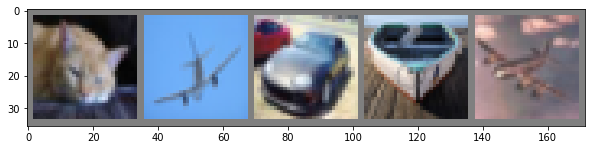

          cat         plane           car          ship         plane


In [6]:
# Getting a batch of images from the dataset and visualising them
dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.figure(figsize=(10,5))
imshow(torchvision.utils.make_grid(images))
# Print image labels
print(' '.join('%13s' % classes[labels[j]] for j in range(len(images))))

In [7]:
import torch.nn as nn
import torch.nn.functional as F
class LeNet_proto(nn.Module):
    def __init__(self):
        super(LeNet_proto, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
#         x = F.softmax(x)
        return x
net = LeNet_proto().to(device)

In [20]:
def classification_prototypes(num_classes):
    """
    A function that initialises class prototypes in a way that places them equidistantly on a hypersphere.
    """
    def inner(num_classes):
        proto = np.zeros((num_classes, num_classes-1))
        proto[0, 0] = 1
        proto[1:, 0] = -1 / (num_classes - 1)
        if num_classes > 2:
            proto[1:, 1:] = inner(num_classes - 1) * np.sqrt(1 - 1 / ((num_classes - 1)**2))
        return proto

    assert num_classes > 1
    return inner(num_classes).astype(np.float32)

class_prototypes = classification_prototypes(10) # Initialising prototypes of 10 classes
class_prototypes = torch.Tensor(class_prototypes).to(device)

In [9]:
def prototype_to_class_certainties(outputs_proto, prototypes):
    """
    A Function that converts model outputs to class certainties, based on the given class prototypes
    """
    outputs_class = F.normalize(outputs_proto, p=2, dim=1)
    outputs_class = torch.mm(outputs_class, prototypes.t())
    return outputs_class

## Training

In [10]:
# Initialising the training parameters
import torch.optim as optim

criterion = nn.CosineSimilarity(eps=1e-8)

max_iteration = len(trainloader) * 20
lambda_poly = lambda iteration: pow((1.0 - iteration / max_iteration), 0.9)

optimizer = optim.Adam(net.parameters())
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_poly)

In [11]:
# Model training
for epoch in range(20):  # loop over the dataset 20 times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Aim to place the inputs as close to their true label prototypes as possible
        targets_proto = class_prototypes[labels] 
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output_proto = net(inputs)
        output_classes = prototype_to_class_certainties(output_proto.detach(), class_prototypes)
        output_classes = output_classes.argmax(axis = 1)

        loss = (1.0 - criterion(output_proto, targets_proto)).pow(2).mean()
        
        loss.backward()
        optimizer.step()
        scheduler.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

D:\Anaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 0.598
[1,  4000] loss: 0.464
[1,  6000] loss: 0.426
[1,  8000] loss: 0.414
[1, 10000] loss: 0.398
[2,  2000] loss: 0.369
[2,  4000] loss: 0.358
[2,  6000] loss: 0.352
[2,  8000] loss: 0.343
[2, 10000] loss: 0.347
[3,  2000] loss: 0.315
[3,  4000] loss: 0.318
[3,  6000] loss: 0.316
[3,  8000] loss: 0.308
[3, 10000] loss: 0.307
[4,  2000] loss: 0.286
[4,  4000] loss: 0.286
[4,  6000] loss: 0.287
[4,  8000] loss: 0.285
[4, 10000] loss: 0.290
[5,  2000] loss: 0.264
[5,  4000] loss: 0.263
[5,  6000] loss: 0.267
[5,  8000] loss: 0.258
[5, 10000] loss: 0.267
[6,  2000] loss: 0.249
[6,  4000] loss: 0.245
[6,  6000] loss: 0.249
[6,  8000] loss: 0.245
[6, 10000] loss: 0.246
[7,  2000] loss: 0.223
[7,  4000] loss: 0.232
[7,  6000] loss: 0.232
[7,  8000] loss: 0.236
[7, 10000] loss: 0.235
[8,  2000] loss: 0.214
[8,  4000] loss: 0.216
[8,  6000] loss: 0.220
[8,  8000] loss: 0.220
[8, 10000] loss: 0.224
[9,  2000] loss: 0.198
[9,  4000] loss: 0.207
[9,  6000] loss: 0.208
[9,  8000] 

In [17]:
# Optionally, save the model to a .pt file
torch.save(net, "model-protonet.pt")

## Evaluation

In [18]:
net = torch.load("model-protonet.pt")

In [25]:
# Evaluate training and validation accuracy

train_hits = []
test_hits = []

for i, data in enumerate(trainloader):
    print(f"Training set... \t{i+1} / {len(trainloader)}", end = '\r')
    inputs, labels = data
    inputs = inputs.to(device)
    pred_proto = prototype_to_class_certainties(net(inputs).detach(), class_prototypes).cpu()

    train_hits.extend(np.array(np.argmax(pred_proto, axis = 1)) == np.array(labels))
    
print("                               ",end='\r')

for i, data in enumerate(testloader):
    print(f"Validation set... \t{i+1} / {len(testloader)}\t", end = '\r')
    inputs, labels = data
    inputs = inputs.to(device)
    pred_proto = prototype_to_class_certainties(net(inputs).detach(), class_prototypes).cpu()

    test_hits.extend(np.array(np.argmax(pred_proto, axis = 1)) == np.array(labels))
    
print("                               ",end='\r')
print(f"Training accuracy: {np.mean(train_hits)*100:.3f}%")
print(f"Validation accuracy: {np.mean(test_hits)*100:.3f}%")

Training accuracy: 80.826%     
Validation accuracy: 61.330%


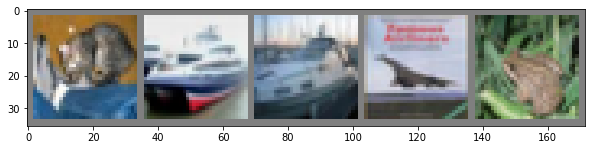

          cat          ship          ship         plane          frog


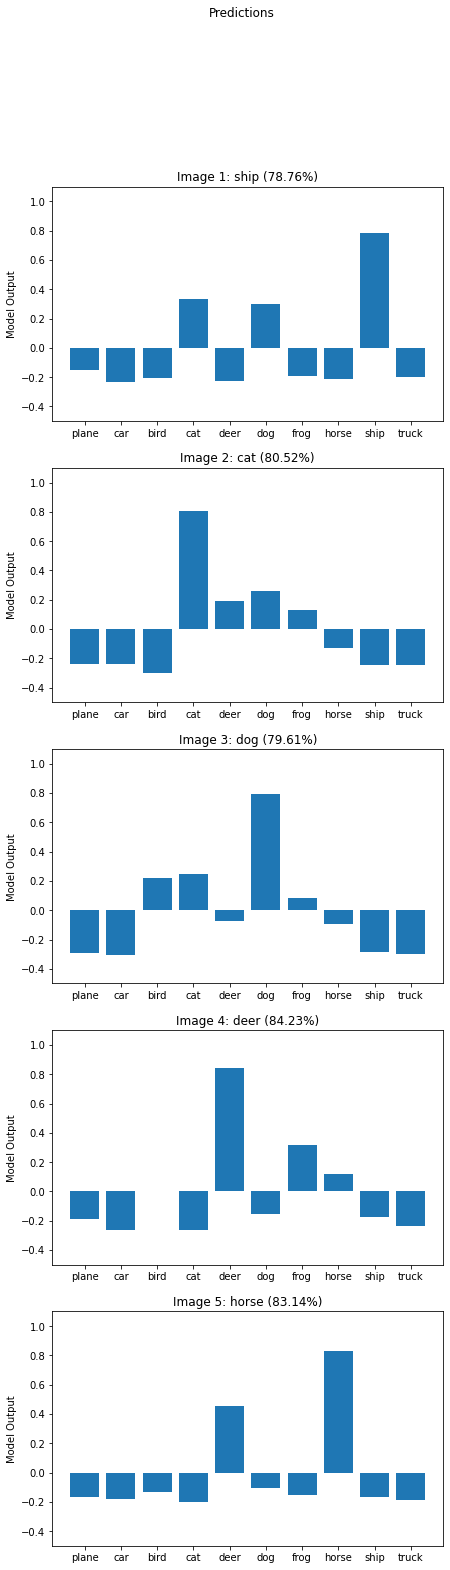

In [27]:
# Predict a batch of validation images and visualise the model output
dataiter = iter(testloader)

images, labels = dataiter.next()
plt.figure(figsize=(10,5))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%13s' % classes[labels[j]] for j in range(len(images))))

images = images.to(device)
net_outputs = prototype_to_class_certainties(net(inputs).detach(), class_prototypes).cpu()

fig, axs = plt.subplots(len(images), 1, figsize=(7,25))
plt.setp(axs, xticks=np.arange(10), xticklabels=classes, ylim=(-0.5,1.1), ylabel="Model Output")
fig.suptitle('Predictions')

for i in range(len(images)):
    axs[i].bar(np.arange(10), np.array(net_outputs[i]))
    axs[i].set_title(f"Image {i+1}: {classes[np.argmax(net_outputs[i])]} ({net_outputs[i].max()*100:.2f}%)")
plt.show()